In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

Setting environment for Gordon


In [2]:
downsample_factor = 16

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [ ]:
# stack = 'MD585'

In [ ]:
# atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))

In [ ]:
# available_labels_sided = [labels_sided[i-1] for i in np.unique(atlasProjected_volume) if i > 0]
# available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [ ]:
# def parallel_where(name, num_samples=None):
    
#     w = np.where(atlasProjected_volume == labels_sided_indices[name])
    
#     if num_samples is not None:
#         n = len(w[0])
#         sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
#         return np.c_[w[1][sample_indices].astype(np.int16), 
#                      w[0][sample_indices].astype(np.int16), 
#                      w[2][sample_indices].astype(np.int16)]
#     else:
#         return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

# t = time.time()

# atlasProjected_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
# atlasProjected_nzs = dict(zip(available_labels_sided, atlasProjected_nzs))

# sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

In [3]:
def compute_score(T, name):
    
#     atlasProjected_centroid = atlasProjected_nzs[name].mean(axis=0)
#     test_centroid2 = atlasProjected_centroid.copy()
    
    atlasProjected_centroid = atlas_centroid_allStacks_allLandmarks[stack][name]
    test_centroid = test_centroid_allStacks_allLandmarks[stack][name]

    atlasProjected_pts_centered = atlasProjected_nzs[name] - atlasProjected_centroid
    
    name_unsided = labelMap_sidedToUnsided[name]
    
    pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered, 
                                 c_prime=test_centroid).astype(np.int16)
                
    xs_prime, ys_prime, zs_prime = pts_prime.T
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
    
    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    return score

In [4]:
# T_final = {}

parameters_allStacks_allLandmarks = defaultdict(dict)
atlas_centroid_allStacks_allLandmarks = defaultdict(dict)
test_centroid_allStacks_allLandmarks = defaultdict(dict)

for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):

#     with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#         lines = f.readlines()
#     T_final[stack] = np.array(map(float, lines[1].strip().split()))
    
    for name in labels_sided:

        tf_fn = atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_%(name)s_transformUponAffineProjection.txt' % \
                            {'stack': stack, 'name': name}
        
        if not os.path.exists(tf_fn):
            continue
        
        with open(tf_fn, 'r') as f:
            lines = f.readlines()
            params = np.array(map(float, lines[0].strip().split()))
            atlas_centroid = np.array(map(float, lines[2].strip().split()))
            test_centroid = np.array(map(float, lines[3].strip().split()))

        parameters_allStacks_allLandmarks[stack][name] = params
        atlas_centroid_allStacks_allLandmarks[stack][name] = atlas_centroid
        test_centroid_allStacks_allLandmarks[stack][name] = test_centroid
        
parameters_allStacks_allLandmarks.default_factory = None
atlas_centroid_allStacks_allLandmarks.default_factory = None
test_centroid_allStacks_allLandmarks.default_factory = None

In [5]:
hessian_tr_allLandmarks = defaultdict(dict)
std_allLandmarks = defaultdict(dict)

In [6]:
import numdifftools as nd
# https://media.readthedocs.org/pdf/numdifftools/latest/numdifftools.pdf

In [7]:
def compute_scores_neighborhood_random(params, name, n, stds):
    
    dparams = np.random.uniform(-1., 1., (n, stds.size)) * stds
        
    scores = Parallel(n_jobs=12)(delayed(compute_score)(params + dp, name) for dp in dparams)
    
    return scores

In [8]:
for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):
# for i, stack in enumerate(['MD589']):
    
    print stack
    
    #############################
    
    atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))

    available_labels_sided = [labels_sided[i-1] for i in np.unique(atlasProjected_volume) if i > 0]
    available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])
    
    def parallel_where(name, num_samples=None):

        w = np.where(atlasProjected_volume == labels_sided_indices[name])

        if num_samples is not None:
            n = len(w[0])
            sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
            return np.c_[w[1][sample_indices].astype(np.int16), 
                         w[0][sample_indices].astype(np.int16), 
                         w[2][sample_indices].astype(np.int16)]
        else:
            return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

    t = time.time()

    atlasProjected_nzs = Parallel(n_jobs=4)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
    atlasProjected_nzs = dict(zip(available_labels_sided, atlasProjected_nzs))

    sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s
    
    ################################
    
    t = time.time()

    volume2_allLabels = {}

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                          {'stack': stack, 'label': name})).astype(np.float16)
        volume2_allLabels[name] = volume2_roi
        del volume2_roi

    test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape

    print test_xdim, test_ydim, test_zdim

    sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))
    
    for name_s in available_labels_sided:
    
        t = time.time()
    
        h = nd.Hessian(lambda t: compute_score(t, name_s), step=np.r_[1e-1, 1e-1, 1e-1, 10,
                                          1e-1, 1e-1, 1e-1, 10,
                                          1e-1, 1e-1, 1e-1, 10])

        H = h(parameters_allStacks_allLandmarks[stack][name_s])
        hessian_tr_allLandmarks[name_s][stack] = H

        sys.stderr.write('Compute hessian %s: %f seconds\n' % (name_s, time.time() - t))

        t = time.time()

        n = 1000
        scores = np.asarray(compute_scores_neighborhood_random(parameters_allStacks_allLandmarks[stack][name_s], name_s, n, 
        np.r_[0, 0, 0, 10., 0, 0, 0, 10., 0, 0, 0, 10.]))
        
        std = np.std(scores.flat)
        std_allLandmarks[name_s][stack] = std
        
        sys.stderr.write('Compute std %s: %f seconds\n' % (name_s, time.time() - t))

        
hessian_tr_allLandmarks.default_factory = None
std_allLandmarks.default_factory = None

MD589


load atlas: 7.381527 seconds
load score volumes: 27.149281 seconds


838 460 454


Compute hessian 12N: 3.253076 seconds
Compute std 12N: 1.383157 seconds
Compute hessian 5N_L: 3.220510 seconds
Compute std 5N_L: 1.477329 seconds
Compute hessian 5N_R: 3.274519 seconds
Compute std 5N_R: 1.478446 seconds
Compute hessian 6N_L: 0.526770 seconds
Compute std 6N_L: 0.478039 seconds
Compute hessian 6N_R: 0.515406 seconds
Compute std 6N_R: 0.607566 seconds
Compute hessian 7N_L: 3.248578 seconds
Compute std 7N_L: 1.480014 seconds
Compute hessian 7N_R: 3.231352 seconds
Compute std 7N_R: 1.476709 seconds
Compute hessian 7n_L: 3.295847 seconds
Compute std 7n_L: 1.378289 seconds
Compute hessian 7n_R: 3.241448 seconds
Compute std 7n_R: 1.383190 seconds
Compute hessian AP: 1.989699 seconds
Compute std AP: 0.976055 seconds
Compute hessian Amb_L: 0.681850 seconds
Compute std Amb_L: 0.774163 seconds
Compute hessian Amb_R: 0.689845 seconds
Compute std Amb_R: 0.680620 seconds
Compute hessian LC_L: 2.877924 seconds
Compute std LC_L: 1.276794 seconds
Compute hessian LC_R: 2.885498 seconds
C

MD594


Compute std VLL_R: 1.484199 seconds
load atlas: 7.510628 seconds
load score volumes: 28.421137 seconds


844 484 443


Compute hessian 12N: 3.249486 seconds
Compute std 12N: 1.483228 seconds
Compute hessian 5N_L: 3.243518 seconds
Compute std 5N_L: 1.390885 seconds
Compute hessian 5N_R: 3.197375 seconds
Compute std 5N_R: 1.386403 seconds
Compute hessian 6N_L: 0.473817 seconds
Compute std 6N_L: 0.387231 seconds
Compute hessian 6N_R: 0.475696 seconds
Compute std 6N_R: 0.485716 seconds
Compute hessian 7N_L: 3.300443 seconds
Compute std 7N_L: 1.483298 seconds
Compute hessian 7N_R: 3.231887 seconds
Compute std 7N_R: 1.481415 seconds
Compute hessian 7n_L: 3.336812 seconds
Compute std 7n_L: 1.486248 seconds
Compute hessian 7n_R: 3.243602 seconds
Compute std 7n_R: 1.496007 seconds
Compute hessian AP: 1.807426 seconds
Compute std AP: 0.884941 seconds
Compute hessian Amb_L: 0.624764 seconds
Compute std Amb_L: 0.696167 seconds
Compute hessian Amb_R: 0.623906 seconds
Compute std Amb_R: 0.705005 seconds
Compute hessian LC_L: 2.600517 seconds
Compute std LC_L: 1.290269 seconds
Compute hessian LC_R: 2.574255 seconds
C

MD585


Compute std VLL_R: 1.487211 seconds
load atlas: 6.912897 seconds
load score volumes: 25.481591 seconds


822 450 438


Compute hessian 12N: 3.202662 seconds
Compute std 12N: 1.594022 seconds
Compute hessian 5N_L: 3.178751 seconds
Compute std 5N_L: 1.384865 seconds
Compute hessian 5N_R: 3.218411 seconds
Compute std 5N_R: 1.382751 seconds
Compute hessian 6N_L: 0.476777 seconds
Compute std 6N_L: 0.391228 seconds
Compute hessian 6N_R: 0.489467 seconds
Compute std 6N_R: 0.497276 seconds
Compute hessian 7N_L: 3.217316 seconds
Compute std 7N_L: 1.482446 seconds
Compute hessian 7N_R: 3.254564 seconds
Compute std 7N_R: 1.476914 seconds
Compute hessian 7n_L: 3.271916 seconds
Compute std 7n_L: 1.486503 seconds
Compute hessian 7n_R: 3.220033 seconds
Compute std 7n_R: 1.506644 seconds
Compute hessian AP: 1.894930 seconds
Compute std AP: 0.886208 seconds
Compute hessian Amb_L: 0.651290 seconds
Compute std Amb_L: 0.787828 seconds
Compute hessian Amb_R: 0.648676 seconds
Compute std Amb_R: 0.686118 seconds
Compute hessian LC_L: 2.722347 seconds
Compute std LC_L: 1.391253 seconds
Compute hessian LC_R: 2.654181 seconds
C

MD590


Compute std VLL_R: 1.481656 seconds
load atlas: 6.609651 seconds
load score volumes: 23.563223 seconds


822 472 397


Compute hessian 12N: 3.267389 seconds
Compute std 12N: 1.481924 seconds
Compute hessian 5N_L: 3.143938 seconds
Compute std 5N_L: 1.392253 seconds
Compute hessian 5N_R: 3.186270 seconds
Compute std 5N_R: 1.376009 seconds
Compute hessian 6N_L: 0.497075 seconds
Compute std 6N_L: 0.398303 seconds
Compute hessian 6N_R: 0.490667 seconds
Compute std 6N_R: 0.393623 seconds
Compute hessian 7N_L: 3.227574 seconds
Compute std 7N_L: 1.515447 seconds
Compute hessian 7N_R: 3.241750 seconds
Compute std 7N_R: 1.589375 seconds
Compute hessian 7n_L: 3.209936 seconds
Compute std 7n_L: 1.396232 seconds
Compute hessian 7n_R: 3.139906 seconds
Compute std 7n_R: 1.478027 seconds
Compute hessian AP: 1.878272 seconds
Compute std AP: 0.983964 seconds
Compute hessian Amb_L: 0.660485 seconds
Compute std Amb_L: 0.682278 seconds
Compute hessian Amb_R: 0.653917 seconds
Compute std Amb_R: 0.672502 seconds
Compute hessian LC_L: 2.754347 seconds
Compute std LC_L: 1.283577 seconds
Compute hessian LC_R: 2.757379 seconds
C

MD593


Compute std VLL_R: 1.368934 seconds
load atlas: 6.910385 seconds
load score volumes: 25.934250 seconds


736 480 456


Compute hessian 12N: 3.202613 seconds
Compute std 12N: 1.386337 seconds
Compute hessian 5N_L: 3.193359 seconds
Compute std 5N_L: 1.483515 seconds
Compute hessian 5N_R: 3.121133 seconds
Compute std 5N_R: 1.377646 seconds
Compute hessian 6N_L: 0.488410 seconds
Compute std 6N_L: 0.480023 seconds
Compute hessian 6N_R: 0.499861 seconds
Compute std 6N_R: 0.479635 seconds
Compute hessian 7N_L: 3.204925 seconds
Compute std 7N_L: 1.590490 seconds
Compute hessian 7N_R: 3.201018 seconds
Compute std 7N_R: 1.485657 seconds
Compute hessian 7n_L: 3.111052 seconds
Compute std 7n_L: 1.404401 seconds
Compute hessian 7n_R: 3.193697 seconds
Compute std 7n_R: 1.602122 seconds
Compute hessian AP: 1.906296 seconds
Compute std AP: 0.987426 seconds
Compute hessian Amb_L: 0.666309 seconds
Compute std Amb_L: 0.691243 seconds
Compute hessian Amb_R: 0.658932 seconds
Compute std Amb_R: 0.680904 seconds
Compute hessian LC_L: 2.737696 seconds
Compute std LC_L: 1.386953 seconds
Compute hessian LC_R: 2.723753 seconds
C

MD592


Compute std VLL_R: 1.589899 seconds
load atlas: 8.113981 seconds
load score volumes: 31.171756 seconds


838 482 470


Compute hessian 12N: 3.186137 seconds
Compute std 12N: 1.390835 seconds
Compute hessian 5N_L: 3.157347 seconds
Compute std 5N_L: 1.488033 seconds
Compute hessian 5N_R: 3.172618 seconds
Compute std 5N_R: 1.397527 seconds
Compute hessian 6N_L: 0.490935 seconds
Compute std 6N_L: 0.594364 seconds
Compute hessian 6N_R: 0.495270 seconds
Compute std 6N_R: 0.499376 seconds
Compute hessian 7N_L: 3.180105 seconds
Compute std 7N_L: 1.501959 seconds
Compute hessian 7N_R: 3.184023 seconds
Compute std 7N_R: 1.497151 seconds
Compute hessian 7n_L: 3.250468 seconds
Compute std 7n_L: 1.491885 seconds
Compute hessian 7n_R: 3.258775 seconds
Compute std 7n_R: 1.614195 seconds
Compute hessian AP: 1.901820 seconds
Compute std AP: 1.011364 seconds
Compute hessian Amb_L: 0.650584 seconds
Compute std Amb_L: 0.701799 seconds
Compute hessian Amb_R: 0.650464 seconds
Compute std Amb_R: 0.690592 seconds
Compute hessian LC_L: 2.739184 seconds
Compute std LC_L: 1.286850 seconds
Compute hessian LC_R: 2.762423 seconds
C

MD591


Compute std VLL_R: 1.494960 seconds
load atlas: 8.514747 seconds
load score volumes: 32.740805 seconds


820 544 451


Compute hessian 12N: 3.255808 seconds
Compute std 12N: 1.498232 seconds
Compute hessian 5N_L: 3.200612 seconds
Compute std 5N_L: 1.397903 seconds
Compute hessian 5N_R: 3.225758 seconds
Compute std 5N_R: 1.494519 seconds
Compute hessian 6N_L: 0.525632 seconds
Compute std 6N_L: 0.593652 seconds
Compute hessian 6N_R: 0.532937 seconds
Compute std 6N_R: 0.609524 seconds
Compute hessian 7N_L: 3.246561 seconds
Compute std 7N_L: 1.505609 seconds
Compute hessian 7N_R: 3.240895 seconds
Compute std 7N_R: 1.499656 seconds
Compute hessian 7n_L: 3.259294 seconds
Compute std 7n_L: 1.402568 seconds
Compute hessian 7n_R: 3.215717 seconds
Compute std 7n_R: 1.400267 seconds
Compute hessian AP: 2.051768 seconds
Compute std AP: 1.008178 seconds
Compute hessian Amb_L: 0.695322 seconds
Compute std Amb_L: 0.699226 seconds
Compute hessian Amb_R: 0.694294 seconds
Compute std Amb_R: 0.792580 seconds
Compute hessian LC_L: 2.960227 seconds
Compute std LC_L: 1.300791 seconds
Compute hessian LC_R: 2.993040 seconds
C

MD595


Compute std VLL_R: 1.604823 seconds
load atlas: 7.815102 seconds
load score volumes: 27.879753 seconds


874 472 448


Compute hessian 12N: 3.283340 seconds
Compute std 12N: 1.495246 seconds
Compute hessian 5N_L: 3.260742 seconds
Compute std 5N_L: 1.491128 seconds
Compute hessian 5N_R: 3.216288 seconds
Compute std 5N_R: 1.502648 seconds
Compute hessian 6N_L: 0.490628 seconds
Compute std 6N_L: 0.597184 seconds
Compute hessian 6N_R: 0.501793 seconds
Compute std 6N_R: 0.515105 seconds
Compute hessian 7N_L: 3.258782 seconds
Compute std 7N_L: 1.617775 seconds
Compute hessian 7N_R: 3.251906 seconds
Compute std 7N_R: 1.500642 seconds
Compute hessian 7n_L: 3.235595 seconds
Compute std 7n_L: 1.395162 seconds
Compute hessian 7n_R: 3.309971 seconds
Compute std 7n_R: 1.497834 seconds
Compute hessian AP: 1.894116 seconds
Compute std AP: 0.912063 seconds
Compute hessian Amb_L: 0.652863 seconds
Compute std Amb_L: 0.717869 seconds
Compute hessian Amb_R: 0.653500 seconds
Compute std Amb_R: 0.708100 seconds
Compute hessian LC_L: 2.751162 seconds
Compute std LC_L: 1.196635 seconds
Compute hessian LC_R: 2.771368 seconds
C

MD598


Compute std VLL_R: 1.512291 seconds
load atlas: 7.216439 seconds
load score volumes: 28.239563 seconds


900 462 410


Compute hessian 12N: 3.231596 seconds
Compute std 12N: 1.502553 seconds
Compute hessian 5N_L: 3.203474 seconds
Compute std 5N_L: 1.396156 seconds
Compute hessian 5N_R: 3.135457 seconds
Compute std 5N_R: 1.478405 seconds
Compute hessian 6N_L: 0.475059 seconds
Compute std 6N_L: 0.496052 seconds
Compute hessian 6N_R: 0.474329 seconds
Compute std 6N_R: 0.513387 seconds
Compute hessian 7N_L: 3.267806 seconds
Compute std 7N_L: 1.490907 seconds
Compute hessian 7N_R: 3.230541 seconds
Compute std 7N_R: 1.494947 seconds
Compute hessian 7n_L: 3.008043 seconds
Compute std 7n_L: 1.398267 seconds
Compute hessian 7n_R: 3.270119 seconds
Compute std 7n_R: 1.486627 seconds
Compute hessian AP: 1.788095 seconds
Compute std AP: 1.000974 seconds
Compute hessian Amb_L: 0.616305 seconds
Compute std Amb_L: 0.597788 seconds
Compute hessian Amb_R: 0.613038 seconds
Compute std Amb_R: 0.592124 seconds
Compute hessian LC_L: 2.583813 seconds
Compute std LC_L: 1.186307 seconds
Compute hessian LC_R: 2.567395 seconds
C

MD602


Compute std VLL_R: 1.509324 seconds
load atlas: 7.414002 seconds
load score volumes: 29.216416 seconds


936 438 424


Compute hessian 12N: 3.306227 seconds
Compute std 12N: 1.512435 seconds
Compute hessian 5N_L: 3.215146 seconds
Compute std 5N_L: 1.394099 seconds
Compute hessian 5N_R: 3.226332 seconds
Compute std 5N_R: 1.531606 seconds
Compute hessian 6N_L: 0.479054 seconds
Compute std 6N_L: 0.491751 seconds
Compute hessian 6N_R: 0.475675 seconds
Compute std 6N_R: 0.592333 seconds
Compute hessian 7N_L: 3.232871 seconds
Compute std 7N_L: 1.499869 seconds
Compute hessian 7N_R: 3.230242 seconds
Compute std 7N_R: 1.506617 seconds
Compute hessian 7n_L: 3.262098 seconds
Compute std 7n_L: 1.421697 seconds
Compute hessian 7n_R: 3.271561 seconds
Compute std 7n_R: 1.611626 seconds
Compute hessian AP: 1.891323 seconds
Compute std AP: 0.905003 seconds
Compute hessian Amb_L: 0.638764 seconds
Compute std Amb_L: 0.600206 seconds
Compute hessian Amb_R: 0.642969 seconds
Compute std Amb_R: 0.696878 seconds
Compute hessian LC_L: 2.664445 seconds
Compute std LC_L: 1.422507 seconds
Compute hessian LC_R: 2.668508 seconds
C

MD603


Compute std VLL_R: 1.604407 seconds
load atlas: 9.122555 seconds
load score volumes: 33.135649 seconds


1056 472 437


Compute hessian 12N: 3.140216 seconds
Compute std 12N: 1.508680 seconds
Compute hessian 5N_L: 3.090319 seconds
Compute std 5N_L: 1.409793 seconds
Compute hessian 5N_R: 3.109730 seconds
Compute std 5N_R: 1.311653 seconds
Compute hessian 6N_L: 0.472980 seconds
Compute std 6N_L: 0.434180 seconds
Compute hessian 6N_R: 0.475527 seconds
Compute std 6N_R: 0.430426 seconds
Compute hessian 7N_L: 3.086697 seconds
Compute std 7N_L: 1.331765 seconds
Compute hessian 7N_R: 3.115432 seconds
Compute std 7N_R: 1.434532 seconds
Compute hessian 7n_L: 3.162971 seconds
Compute std 7n_L: 1.335931 seconds
Compute hessian 7n_R: 3.137984 seconds
Compute std 7n_R: 1.409685 seconds
Compute hessian AP: 1.820450 seconds
Compute std AP: 0.911343 seconds
Compute hessian Amb_L: 0.623201 seconds
Compute std Amb_L: 0.714642 seconds
Compute hessian Amb_R: 0.629789 seconds
Compute std Amb_R: 0.712309 seconds
Compute hessian LC_L: 2.578147 seconds
Compute std LC_L: 1.121992 seconds
Compute hessian LC_R: 2.604889 seconds
C

In [ ]:
# hessian_tr_allLandmarks2 = defaultdict(dict)

# for stack, hessians in hessian_tr_allLandmarks.iteritems():
#     for name_s, h in hessians.iteritems():
#         hessian_tr_allLandmarks2[name_s][stack] = h
        
# hessian_tr_allLandmarks2.default_factory = None


# std_allLandmarks2 = defaultdict(dict)

# for stack, stds in std_allLandmarks2.iteritems():
#     for name_s, std in stds.iteritems():
#         std_allLandmarks2[name_s][stack] = std
        
# std_allLandmarks2.default_factory = None

In [9]:
pickle.dump(hessian_tr_allLandmarks, open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/hessian_individualAlign_allStacks_allLandmarks.pkl', 'w'))
pickle.dump(std_allLandmarks, open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/std_individualAlign_allStacks_allLandmarks.pkl', 'w'))

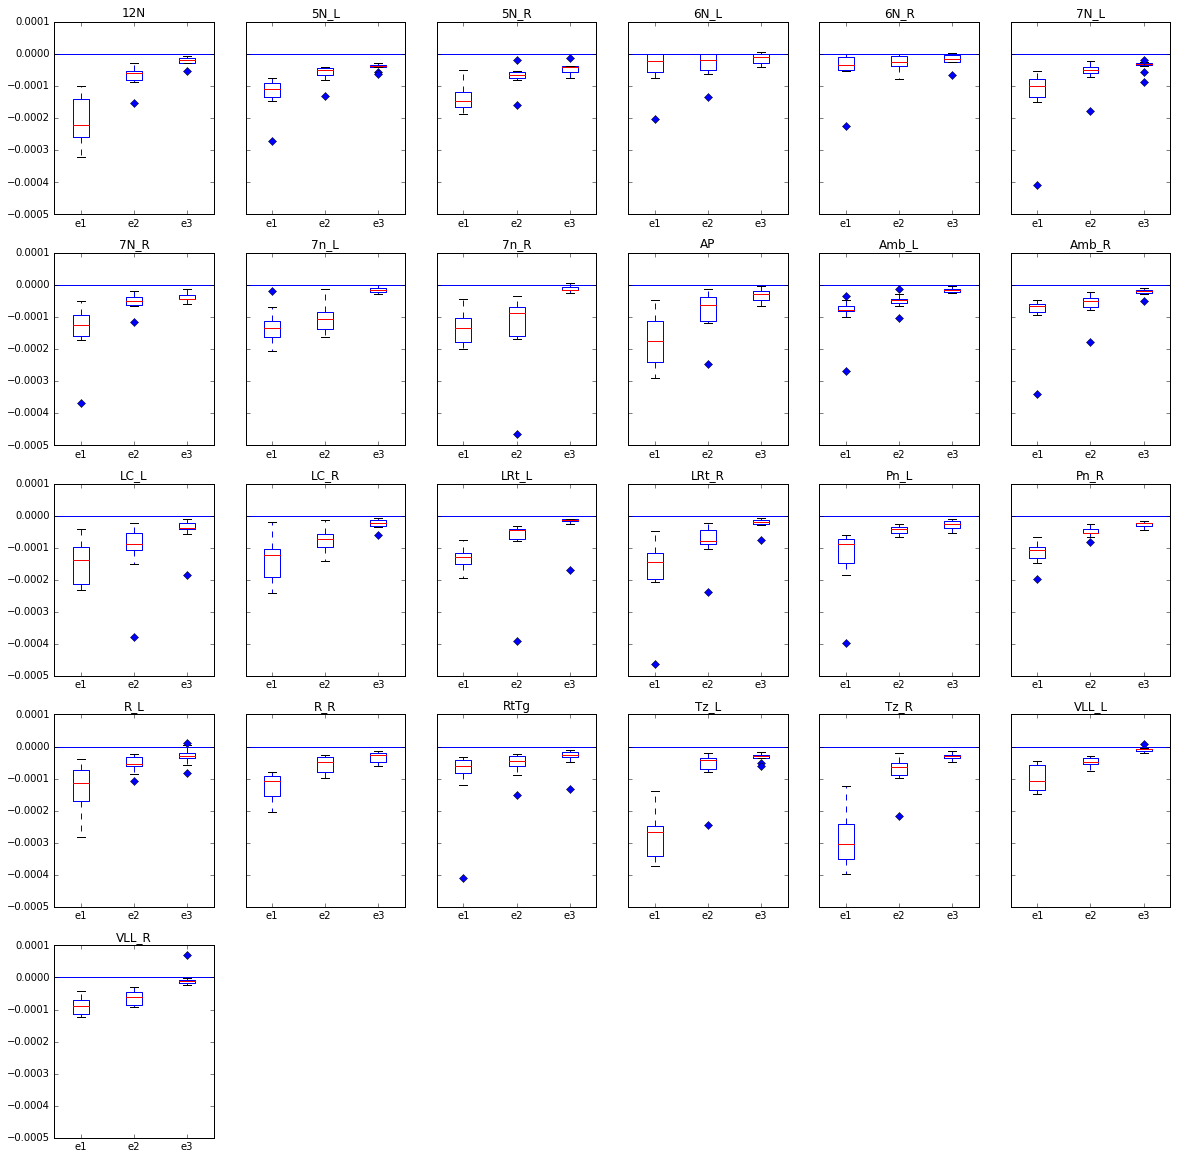

In [22]:
# n_lm = len(hessian_tr_allLandmarks)

# fig, axes = plt.subplots(int(np.ceil(n_lm/6.)), 6, 
#                          figsize=(20, 20), squeeze=True, sharey=True)

# axes = axes.flatten()

# V = defaultdict(dict)
# S = defaultdict(dict)

# for li, name_s in enumerate(sorted(hessian_tr_allLandmarks.keys())):

#     hs = hessian_tr_allLandmarks[name_s]

#     for stack, h in hs.iteritems():
        
#         q = np.r_[3,7,11]
#         h_tr = h[q[:,None], q]
#         s, v = np.linalg.eigh(h_tr)
#         S[name_s][stack] = s
#         V[name_s][stack] = v
        
#     axes[li].set_title(name_s);
        
#     axes[li].boxplot(np.r_[[ss for ss in S[name_s].itervalues() if all(~np.isnan(ss))]], 0, 'gD');

#     axes[li].set_xticks(range(1, 4));
#     axes[li].set_xticklabels(['e1', 'e2', 'e3']);

#     axes[li].axhline(0);
    
#     axes[li].set_ylim([-0.0005, 0.0001]);
    
    
# for li in range(n_lm, len(axes)):
#     axes[li].set_visible(False) 

# plt.show();

In [148]:
# eigenvalue normalized by std in the neighborhood

n_lm = len(hessian_tr_allLandmarks)

# fig, axes = plt.subplots(int(np.ceil(n_lm/6.)), 6, 
#                          figsize=(20, 20), squeeze=True, sharey=True)

# axes = axes.flatten()

V = defaultdict(dict)
S = defaultdict(dict)
S1 = defaultdict(dict)

for li, name_s in enumerate(sorted(hessian_tr_allLandmarks.keys())):

    hs = hessian_tr_allLandmarks[name_s]

    for stack, h in hs.iteritems():
        
        std = std_allLandmarks[name_s][stack]
        if std < 1e-5:
            sys.stderr.write('std is close to zero: %s, %s.\n' % (name_s, stack))
        
        q = np.r_[3,7,11]
        h_tr = h[q[:,None], q]
        s, v = np.linalg.eigh(h_tr)
        
        if any(s > 0):
            sys.stderr.write('some eigenvalues are greater than zero: %s, %s.\n' % (name_s, stack))
#             print s
            
        S[name_s][stack] = 1./2. * 10**2 * s[2]/std
        S1[name_s][stack] = 1./2. * 10**2 * s[0]/std
#         S[name_s][stack] = 1./6. * (5**2+5*20+20**2)* s[2]/std
#         S1[name_s][stack] = 1./6. * (5**2+5*20+20**2)* s[0]/std
        V[name_s][stack] = v
        
#     axes[li].set_title(name_s);

some eigenvalues are greater than zero: 5N_R, MD603.
std is close to zero: 6N_L, MD602.
some eigenvalues are greater than zero: 6N_L, MD602.
std is close to zero: 6N_L, MD593.
some eigenvalues are greater than zero: 6N_L, MD593.
some eigenvalues are greater than zero: 6N_L, MD585.
std is close to zero: 6N_L, MD595.
some eigenvalues are greater than zero: 6N_L, MD595.
std is close to zero: 6N_R, MD602.
some eigenvalues are greater than zero: 6N_R, MD602.
some eigenvalues are greater than zero: 6N_R, MD590.
some eigenvalues are greater than zero: 7n_R, MD592.
some eigenvalues are greater than zero: Tz_L, MD603.
some eigenvalues are greater than zero: VLL_L, MD603.
some eigenvalues are greater than zero: VLL_R, MD603.


In [126]:
keys = sorted(hessian_tr_allLandmarks.keys())
arr_to_plot = np.column_stack(np.c_[S[name_s].values(), S1[name_s].values()] for name_s in keys)

In [127]:
plot_labels = list(chain(*[[name_s, name_s] for name_s in keys]))

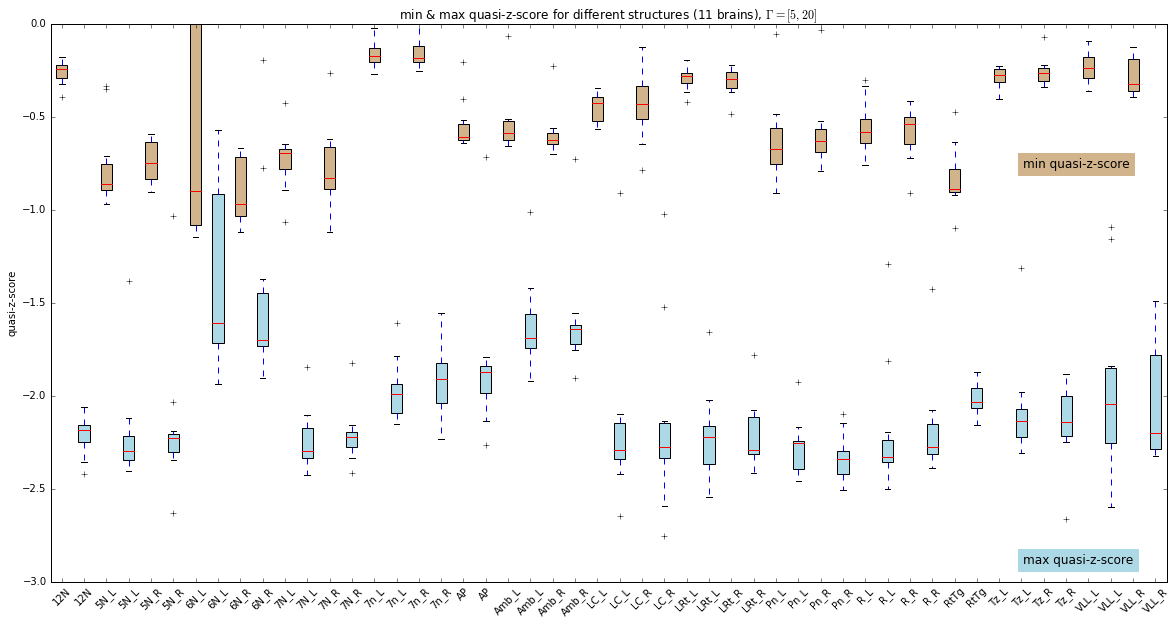

In [151]:
plt.figure(figsize=(20,10));

box = plt.boxplot(arr_to_plot, notch=False, sym='+', patch_artist=True);
colors = ['tan', 'lightblue'] * len(keys)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('k')
    
plt.axhline(0);
# plt.gca().set_ylim([-5., 0]);
plt.gca().set_ylim([-3., 0]);
plt.xticks(range(1, arr_to_plot.shape[1]+1), plot_labels, rotation=45);

plt.figtext(0.80, 0.7, 'min quasi-z-score', backgroundcolor='tan', weight='roman',
            size='large');

plt.figtext(0.80, 0.15, 'max quasi-z-score', backgroundcolor='lightblue', weight='roman',
            size='large');

plt.ylabel('quasi-z-score');
plt.title('min & max quasi-z-score for different structures (11 brains), $\Gamma=[5,20]$');

plt.show();

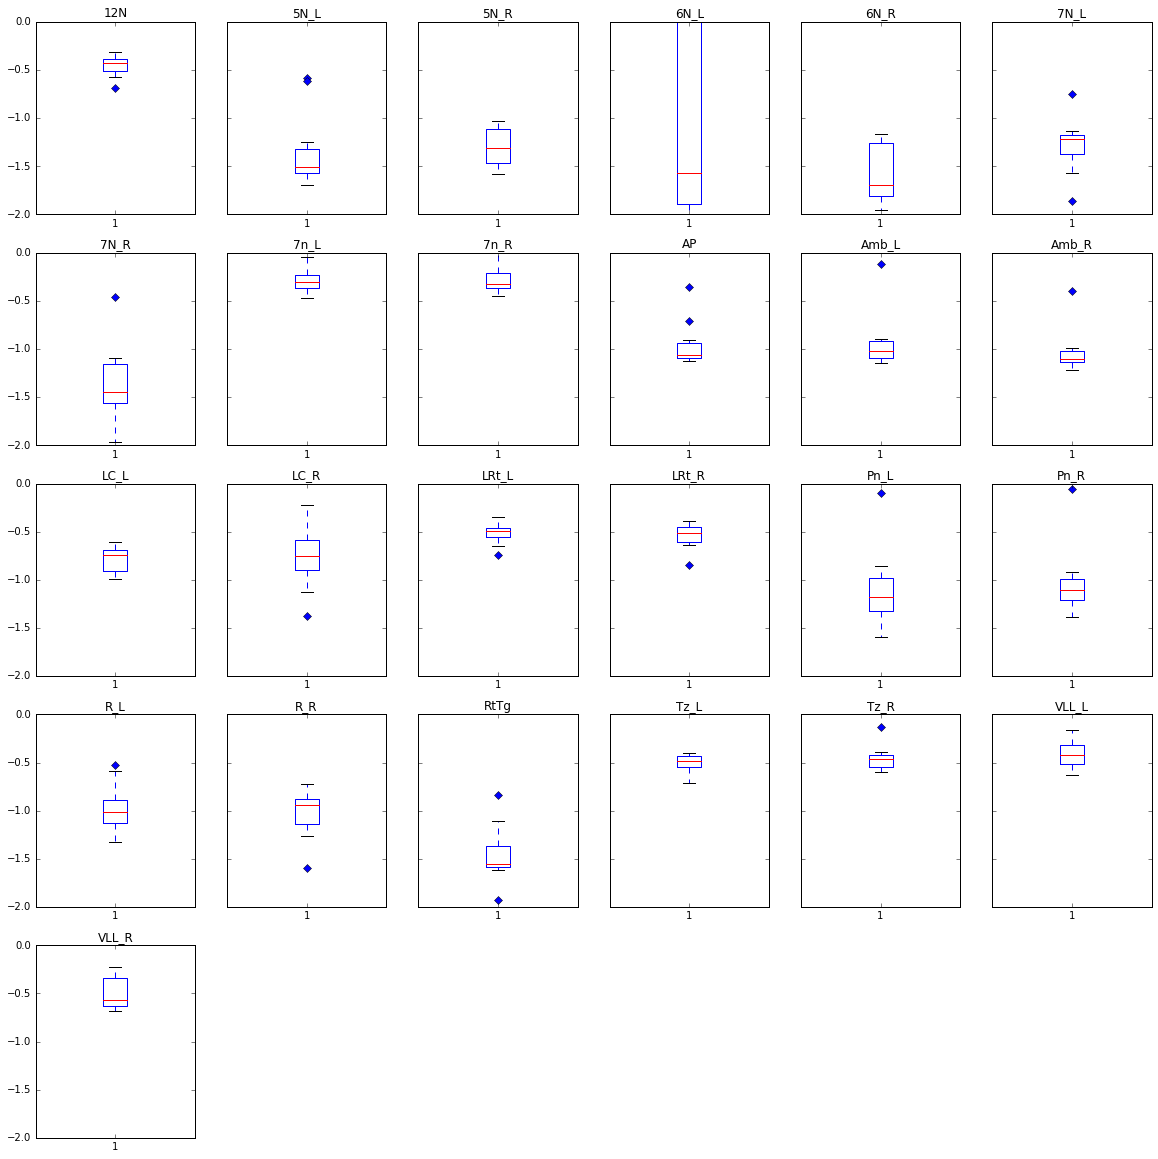

In [26]:
# # eigenvalue normalized by std in the neighborhood

# n_lm = len(hessian_tr_allLandmarks)

# fig, axes = plt.subplots(int(np.ceil(n_lm/6.)), 6, 
#                          figsize=(20, 20), squeeze=True, sharey=True)

# axes = axes.flatten()

# V = defaultdict(dict)
# S = defaultdict(dict)

# for li, name_s in enumerate(sorted(hessian_tr_allLandmarks.keys())):

#     hs = hessian_tr_allLandmarks[name_s]

#     for stack, h in hs.iteritems():
        
#         std = std_allLandmarks[name_s][stack]
        
#         q = np.r_[3,7,11]
#         h_tr = h[q[:,None], q]
#         s, v = np.linalg.eigh(h_tr)
# #         S[name_s][stack] = 1./2. * 10**2 * s[2]/std
#         S[name_s][stack] = 1./6. * (5**2+5*20+20**2)* s[2]/std
#         V[name_s][stack] = v
        
#     axes[li].set_title(name_s);
    
#     axes[li].boxplot(S[name_s].values(), 0, 'gD');

# #     axes[li].boxplot(S.T, 0, 'rs', 0);
# #     axes[li].set_xlim([-1e-4, 1e-4]);
    
# #     axes[li].set_xticks(np.arange(0, 10.));
# #     axes[li].set_xticklabels(['e1', 'e2', 'e3']);
    
# #     axes[li].set_xticks(range(1, 4));
# #     axes[li].set_xticklabels(['e1', 'e2', 'e3']);

#     axes[li].axhline(0);
    
#     axes[li].set_ylim([-2., 0]);
    
    
# for li in range(n_lm, len(axes)):
#     axes[li].set_visible(False) 

# plt.show();

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


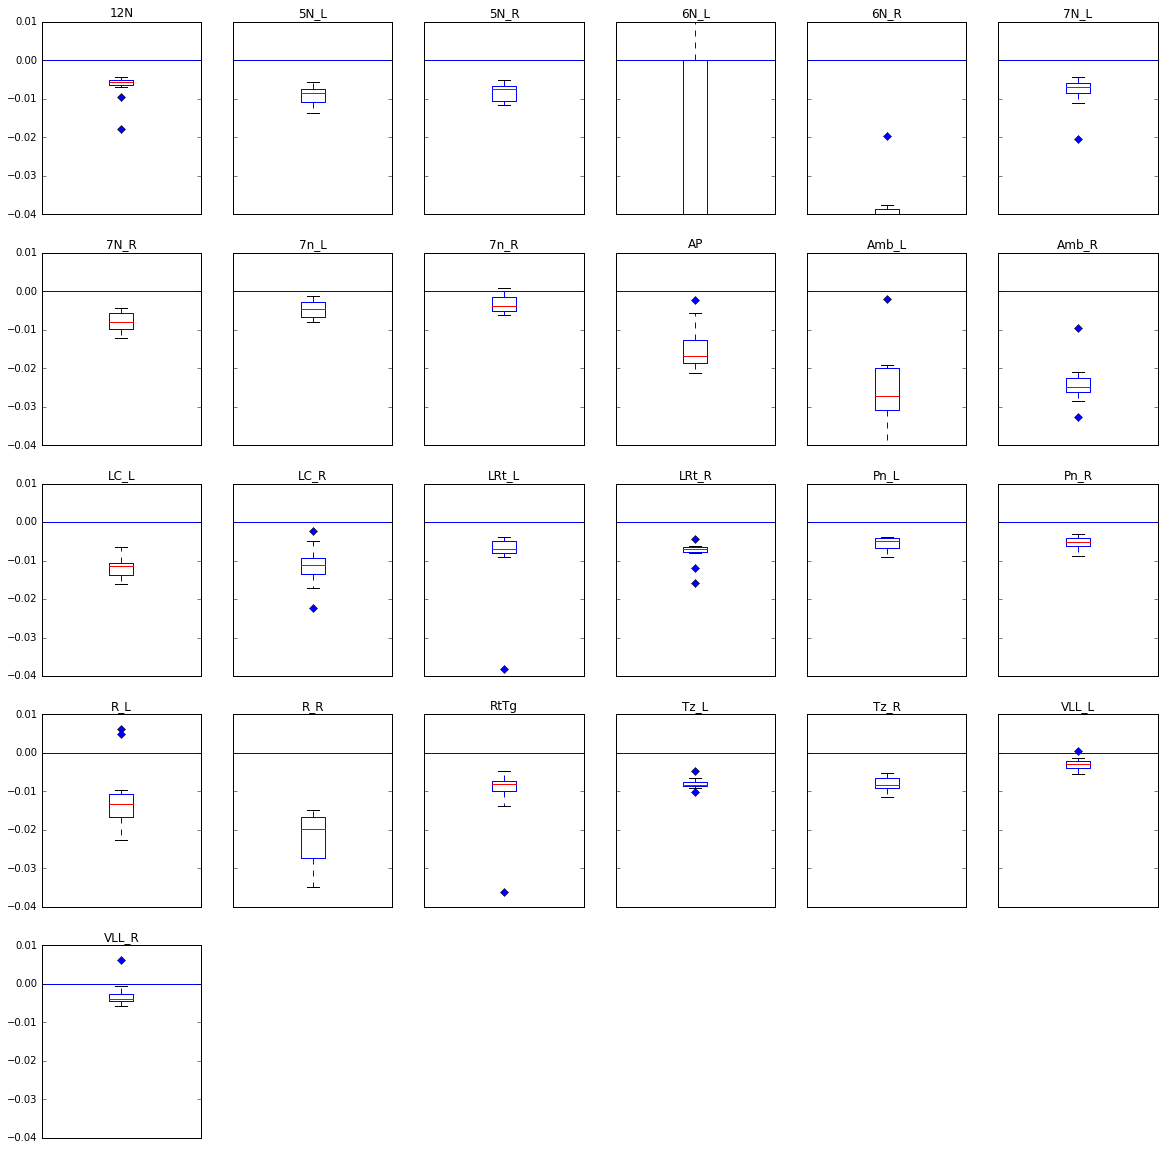

In [24]:
# # std-normalized third (smallest) eigenvalue

# n_lm = len(hessian_tr_allLandmarks)

# fig, axes = plt.subplots(int(np.ceil(n_lm/6.)), 6, 
#                          figsize=(20, 20), squeeze=True, sharey=True)

# axes = axes.flatten()

# V = defaultdict(dict)
# S = defaultdict(dict)

# for li, name_s in enumerate(sorted(hessian_tr_allLandmarks.keys())):

#     hs = hessian_tr_allLandmarks[name_s]

#     for stack, h in hs.iteritems():
        
#         std = std_allLandmarks[name_s][stack]
        
#         q = np.r_[3,7,11]
#         h_tr = h[q[:,None], q]
#         s, v = np.linalg.eigh(h_tr)
#         S[name_s][stack] = s/std
#         V[name_s][stack] = v
        
#     axes[li].set_title(name_s);
    
#     axes[li].boxplot(np.r_[[ss[2] for ss in S[name_s].itervalues() if all(~np.isnan(ss))]], 0, 'gD');


#     axes[li].set_xticks(range(1));
#     axes[li].set_xticklabels(['e3']);

#     axes[li].axhline(0);
    
#     axes[li].set_ylim([-0.04, 0.01]);
    
    
# for li in range(n_lm, len(axes)):
#     axes[li].set_visible(False) 

# plt.show();

In [ ]:
for v in hessian_tr_allLandmarks2['7N_L'].values():
    plt.matshow(v, cmap=plt.cm.gray, vmin=-1e-4, vmax=0);
    plt.colorbar();
    plt.show();